# Progetto 2021

In [22]:
SEED = 9246
import os


import json
import time
from datetime import datetime
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models

from PIL import Image

from skimage import io
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report

import torchsummary

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device("cuda" if CUDA else "cpu")


In [2]:
DATASET_DIR = 'progetto_2021_dataset' #questo è il dataset
DRIVE_FOLDER = 'progetto_2021_dataset/model_checkpoint'#dati di salvataggio della computazione in modo di riprendere da dove ho lasciato

JSON_DATA = os.path.join(DATASET_DIR, 'train_test_split_dict.json')#nome del file json contenente suddivisione train/test

with open(JSON_DATA) as fp:
    dataset_json = json.load(fp)
    
len(dataset_json)

2

In [3]:
labels = set()

for k in dataset_json.values():
    for lable_list in k.values():
        for v in lable_list:
            labels.add(v)
            
label_idx = {v: i for i, v in enumerate(sorted(labels))} #le etichette sono stringhe, quindi le codifico. 
                                                            #questo perchè uso un dataloader custom

# Load data

Caricamento di training e test set. In particolare di ogni trailer carichiamo le prime 20 immagini (se ci sono, se invece il trailer presenta meno di 20 immagini, carichiamo solo quelle che ci sono). 
Sui frame è applicato prima un center crop e poi una resize di dimensione 64x64. 

In [5]:
#data loader:
class VideoDataset(Dataset):
                                                                    #limite: numero di frame max che voglio caricare
    def __init__(self, dataset_folder, labels_dict, transform=None, limit=30):
        """
        Args:
            dataset_folder (string): Path to the folder with mp4 files.
            labels_dict (dict): dict filename - list of label.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_dict = labels_dict
        self.root_dir = dataset_folder
        self.limit = limit
        self.transform = transform or torchvision.transforms.ToTensor()
        
        self._files = np.array(list(self.labels_dict.keys()))

    def __len__(self):
        return len(self.labels_dict)

    def __getitem__(self, idx): #idx è l'indice dell'i-esimo trailer da caricare
        name = self._files[idx]
                        #self.limit è il numero di trailer
        folder_pattern = os.path.join(self.root_dir, name, '*.png')#leggo tutte le png presenti nella folder dell'iesimo trailer
        images = io.imread_collection(folder_pattern)
        if len(images)>20:
            self.limit = 20
        else:
            self.limit = len(images)
        x = torch.zeros(self.limit, 3, 64,64) #riempio un tensore di zeri 
        
        
        for i, image in enumerate(images):
            if i < self.limit:
                image = self.transform(Image.fromarray(image))
                x[i] = image.unsqueeze(0)

        labels = torch.zeros(len(label_idx), dtype=torch.float32)
        for label in self.labels_dict[name]:
            labels[label_idx[label]] = 1 #assegno il valore 1 per etichettare le classi corrispondenti
        
        return x, labels
    
    def get_labels(self,idx):
        name = datasetTrain._files[idx]
        etichette = datasetTrain.labels_dict[name]
        return etichette

                                #effettuo un center crop a 224
transformations = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(224),torchvision.transforms.Resize(64),
                                                  torchvision.transforms.ToTensor()])

datasetTrain = VideoDataset(DATASET_DIR, dataset_json['train'], transformations)
datasetTest = VideoDataset(DATASET_DIR, dataset_json['test'], transformations)

Creiamo un dizionario <k,v> dove k è l'etichetta di classe e v è la sua numerosità nel training set. 

In [7]:
etichet = {}
for i in range(len(datasetTrain)):
    l = datasetTrain.get_labels(i)
    for j in l:
        if j in etichet:
            etichet[j]=etichet[j]+1
        else:
            etichet[j]=1

In [8]:
print(sorted(etichet.items(),key=lambda x : x[1],reverse=True))

[('drama', 2133), ('comedy', 773), ('action', 717), ('thriller', 554), ('crime', 515), ('horror', 502), ('scifi', 436), ('romantic', 413), ('fantasy', 358), ('romantic_comedy', 294), ('adventure', 294), ('comedy_drama', 269), ('LGBT', 265), ('musical', 236), ('biopic', 232), ('mystery', 222), ('war', 222), ('wartime', 221), ('documentary', 114), ('western', 109), ('noir', 106), ('supernatural', 98), ('sexual', 93), ('serial_killer', 92), ('animation', 92), ('splatter', 89), ('horror_comedy', 86), ('aviation', 84), ('violence', 82), ('dystopic', 81), ('monsters', 80), ('revenge', 79), ('teen_movie', 78), ('futuristic', 76), ('neo-noir', 71), ('bank_robbery', 70), ('espionage', 69), ('love', 69), ('martial_arts', 68), ('chase', 67), ('terrorism', 66), ('space', 65), ('history', 64), ('zombies', 62), ('family', 61), ('prison', 58), ('politics', 54), ('suspenseful', 53), ('nudity', 53), ('time_travel', 49), ('vampires', 49), ('murder', 47), ('children', 47), ('fight_scenes', 47), ('sport',

In [9]:
etichet.items()

dict_items([('crime', 515), ('drama', 2133), ('action', 717), ('western', 109), ('horror', 502), ('politics', 54), ('documentary', 114), ('music', 40), ('musical', 236), ('LGBT', 265), ('comedy', 773), ('mystery', 222), ('thriller', 554), ('fantasy', 358), ('romantic_comedy', 294), ('romantic', 413), ('alien', 45), ('dystopic', 81), ('teen_movie', 78), ('space', 65), ('futuristic', 76), ('scifi', 436), ('adventure', 294), ('high_school', 36), ('true_story', 29), ('biopic', 232), ('espionage', 69), ('chase', 67), ('terrorism', 66), ('comedy_drama', 269), ('time_travel', 49), ('war', 222), ('surreal', 25), ('vampires', 49), ('monsters', 80), ('creepy', 33), ('aviation', 84), ('prison', 58), ('zombies', 62), ('magic', 36), ('wartime', 221), ('murder', 47), ('noir', 106), ('children', 47), ('sexual', 93), ('police_investigation', 37), ('death_penalty', 24), ('serial_killer', 92), ('supernatural', 98), ('pornography', 16), ('animation', 92), ('pirates', 24), ('religion', 27), ('erotic_thril

Creiamo i pesi per gestire lo sbilanciamento delle classi. In particolare utilizziamo un peso inversamente proporzionale alla numerosità della classe. 

In [23]:
pesi_a = []

for k in sorted(labels):
    pesi_a.append(1/etichet[k])
pesi = torch.tensor(pesi_a)

In [11]:
pesi

tensor([0.0038, 0.0014, 0.0455, 0.0034, 0.0400, 0.0222, 0.0109, 0.0119, 0.0143,
        0.0043, 0.0312, 0.0149, 0.0213, 0.0013, 0.0037, 0.0256, 0.0303, 0.0019,
        0.0323, 0.0400, 0.0417, 0.0227, 0.0088, 0.0005, 0.0123, 0.0345, 0.0145,
        0.0164, 0.0028, 0.0213, 0.0417, 0.0132, 0.0345, 0.0278, 0.0156, 0.0020,
        0.0116, 0.0323, 0.0400, 0.0400, 0.0145, 0.0278, 0.0147, 0.0312, 0.0125,
        0.0213, 0.0250, 0.0042, 0.0045, 0.0141, 0.0094, 0.0189, 0.0323, 0.0417,
        0.0270, 0.0185, 0.0625, 0.0172, 0.0500, 0.0370, 0.0127, 0.0024, 0.0034,
        0.0023, 0.0109, 0.0108, 0.0345, 0.0154, 0.0112, 0.0217, 0.0323, 0.0102,
        0.0400, 0.0189, 0.0128, 0.0152, 0.0018, 0.0204, 0.0345, 0.0204, 0.0122,
        0.0045, 0.0045, 0.0092, 0.0161])

# Data visualization

In seguito di graficano le classi più numerose e le classi meno numerose. 

[Text(0, 0, 'death'),
 Text(0, 0, 'loneliness'),
 Text(0, 0, 'justice'),
 Text(0, 0, 'alcohol_addiction'),
 Text(0, 0, 'death_penalty'),
 Text(0, 0, 'pirates'),
 Text(0, 0, 'friendship'),
 Text(0, 0, 'action_comedies'),
 Text(0, 0, 'prostitution'),
 Text(0, 0, 'pornography')]

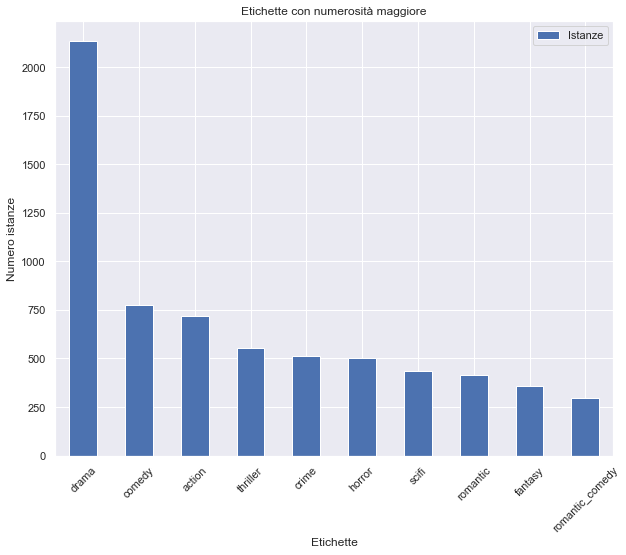

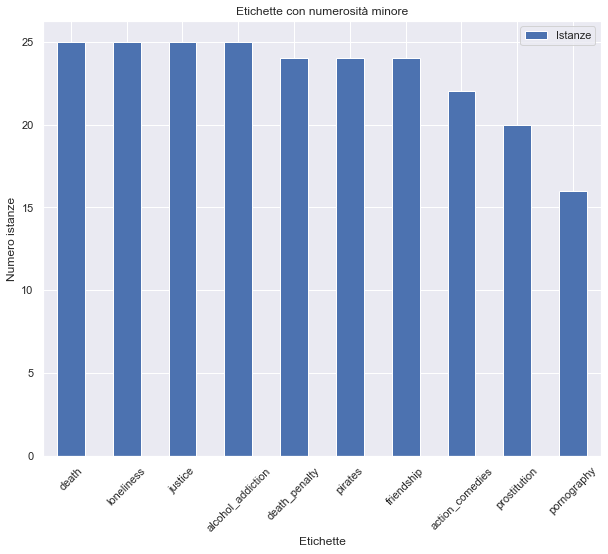

In [24]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(sorted(etichet.items(),key=lambda x : x[1],reverse=True))
#df= df.sort_values(df['0'])
df.columns = ['Etichetta','Istanze']
df.index = df['Etichetta'] 
top10 = df.head(10)
flop10 = df.tail(10)


sns.set(rc={'figure.figsize':(10,8)})
grafico=top10.plot.bar()
grafico.set_title('Etichette con numerosità maggiore')
grafico.set_ylabel('Numero istanze')
grafico.set_xlabel('Etichette')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45)


sns.set(rc={'figure.figsize':(10,8)})
grafico=flop10.plot.bar()
grafico.set_title('Etichette con numerosità minore')
grafico.set_ylabel('Numero istanze')
grafico.set_xlabel('Etichette')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45)

# Mini dataset

Sono stati costruiti un mini-training set e un mini-test set di dimensione 1/10 rispetto alle dimensioni originali che permettessero di fare prove veloci.
Entrambi i dataset ridotti rispecchiano le proporzioni di classe del dataset di partenza.

In [25]:
numerosità = []
for e,f in sorted(etichet.items(),key=lambda x : x[1],reverse=True):
    numerosità.append(int(f/10))

rid_dict = {v[0]: numerosità[i] for i,v in enumerate(sorted(etichet.items(),key=lambda x : x[1],reverse=True))}
print(rid_dict)

{'drama': 213, 'comedy': 77, 'action': 71, 'thriller': 55, 'crime': 51, 'horror': 50, 'scifi': 43, 'romantic': 41, 'fantasy': 35, 'romantic_comedy': 29, 'adventure': 29, 'comedy_drama': 26, 'LGBT': 26, 'musical': 23, 'biopic': 23, 'mystery': 22, 'war': 22, 'wartime': 22, 'documentary': 11, 'western': 10, 'noir': 10, 'supernatural': 9, 'sexual': 9, 'serial_killer': 9, 'animation': 9, 'splatter': 8, 'horror_comedy': 8, 'aviation': 8, 'violence': 8, 'dystopic': 8, 'monsters': 8, 'revenge': 7, 'teen_movie': 7, 'futuristic': 7, 'neo-noir': 7, 'bank_robbery': 7, 'espionage': 6, 'love': 6, 'martial_arts': 6, 'chase': 6, 'terrorism': 6, 'space': 6, 'history': 6, 'zombies': 6, 'family': 6, 'prison': 5, 'politics': 5, 'suspenseful': 5, 'nudity': 5, 'time_travel': 4, 'vampires': 4, 'murder': 4, 'children': 4, 'fight_scenes': 4, 'sport': 4, 'alien': 4, 'disaster_movie': 4, 'music': 4, 'coming_of_age': 3, 'police_investigation': 3, 'high_school': 3, 'magic': 3, 'creepy': 3, 'melodrama': 3, 'cartoon

In [26]:
def mini_annotation2idlist(annotations):
    l=[]
    for q in range(int(len(annotations))):
        for etichetta in annotations.get_labels(q):
            if rid_dict[etichetta]!=0:
                l.append(annotations.__getitem__(q))
                rid_dict[etichetta]-=1
        
    return l
mini_id_train = mini_annotation2idlist(datasetTrain)
mini_id_test = mini_annotation2idlist(datasetTest)

# Loading model

In [15]:
CHECKPOINT = os.path.join('C:/Users/Utente/Desktop/Università/Magistrale/secondo anno/secondo semestre/analisi di immagini e video/es progetto/cv_notebooks-master/project_1/chpt'
    , 'model.checkpoint')
MODELFILE = os.path.join('C:/Users/Utente/Desktop/Università/Magistrale/secondo anno/secondo semestre/analisi di immagini e video/es progetto/cv_notebooks-master/project_1/chpt'
    , 'model.pth')

def save_checkpoint(epoch, model, optimizer, loss): #salvo lo stato. Nel caso minimo mi salvo loss, ottimizzatore, modello e num epoche
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, CHECKPOINT)

def load_checkpoint(model, optimizer):
    if not os.path.exists(CHECKPOINT):
        return None, None
    checkpoint = torch.load(CHECKPOINT)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return epoch, loss

def save_model(model): #salvo la configurazione dei pesi del modello
    torch.save(model.state_dict(), MODELFILE) #modelfile è il path in cui salvare il modello

def load_model(model):
    if os.path.exists(MODELFILE):
        model.load_state_dict(torch.load(MODELFILE))


# Creazione della rete di classificazione

La rete utilizzata è una VGG19 pretrained. In particolare la rete è stata riadattata a restituire dalla parte convoluzionale delle feature map di dimensione 512x2x2, che sono passate (sistemate come spiegato in seguito) in input alla parte di classificazione, anch'essa riadattata, aggiungendo una serie di livelli densi che in linea di massima dimezzano ogni volta le dimensioni della feature map ricevuta. 
Chiaramente cruciale è la funzione di forward, in cui la rete date le 20 feature map restituite dal livello convoluzionale effettua una media, avendo quindi come risultato una feature map unica di dimensione 512x2x2, che è passata in input ai livelli di classificazione. 
L'aggiornamento dei pesi della parte convoluzionale, che comunque è preaddestrata, è disattivato per motivi di eccessiva lentezza dei test. 


In [27]:
class VGG(nn.Module):

    def __init__(self, start_model, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features 
        for param in self.features.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024,1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024,512),
            nn.ReLU(True),
            nn.Dropout(),
            
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        frame,channel,w,h = x.shape
        x2 = x.view(1*frame,channel,x.size(2),x.size(3))#(bs * frame, 3, W, H) assumo batch size 1 #inutile
        fm_di_x2 = self.features(x2)#dimensione effettiva: 30x512x1x1 #30x512xdim singola feature map
        media_fm = torch.zeros(512,1,1)
        cnt = 0
        for j in range(fm_di_x2.shape[0]):
            cnt+=1
            media_fm = media_fm + fm_di_x2[j].unsqueeze(0)
        media_fm = media_fm/cnt
        x3 = media_fm.view(1,media_fm.size(0)*media_fm.size(1)*media_fm.size(2)*media_fm.size(3))
        x = self.classifier(x3)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

model1 = torchvision.models.vgg19(pretrained=True)
model = VGG(model1,model1.features,85)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Training del modello

Per fare il traning del modello è stato utilizzato un learning rate di 0.01 e l'ottimizzatore SGD, inserendo il momentum in modo da evitare che il modello si blocchi in dei punti di minimo locale. 
La funzione di loss utilizzata è la Binary Cross entropy.

In [14]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9,nesterov=True)
error = nn.BCEWithLogitsLoss(pos_weight=pesi) 

Training: evitare di eseguire nel caso in cui si voglia solo eseguire il test

In [17]:
last_epoch,lss = load_checkpoint(model, optimizer)
epochs = 2
train_losses = []

print_every = 100
try:                   
    if(last_epoch == None):
        last_epoch = -1
    for epoch in range(last_epoch + 1, epochs):
        print('Start epoch', epoch+1)
        model.train()
        running_loss = 0
        steps = 0
       
        for n,(x, y) in enumerate(datasetTrain):
          
            steps += 1
            x, y = x.to(device), y.to(device)
            
            if epoch == 0 and steps == 1:
                print(f'input shape is {x.shape}, labels are {y.shape}')

            optimizer.zero_grad()
        
            logit_v = model(x)
            logit = logit_v.view(logit_v.size(1))
            
            
            loss = error(logit, y)
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
        
            
            if steps % print_every == 0:
                print(f"epoch {epoch+1}/{epochs} "
                      f"train loss: {running_loss/steps:.6f} ")

                save_checkpoint(epoch, model, optimizer, loss)

        save_model(model)
        train_losses.append(running_loss/steps)
        print(f"END Epoch {epoch+1}/{epochs} "
              f"Train loss: {running_loss/steps:.6f} ")
        
        
except KeyboardInterrupt: #gestendo l'eventuale eccezione salvo comunque il modello in modo da non perderlo
    print('Exiting from training early')

save_model(model)

Start epoch 1
input shape is torch.Size([20, 3, 64, 64]), labels are torch.Size([85])


C:\Users\Utente\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 1/2 train loss: 0.658560 
epoch 1/2 train loss: 0.646216 
epoch 1/2 train loss: 0.633268 
epoch 1/2 train loss: 0.620148 
epoch 1/2 train loss: 0.606279 
epoch 1/2 train loss: 0.591522 
epoch 1/2 train loss: 0.574466 
epoch 1/2 train loss: 0.552116 
epoch 1/2 train loss: 0.522139 
epoch 1/2 train loss: 0.485333 
epoch 1/2 train loss: 0.446393 
epoch 1/2 train loss: 0.411015 
epoch 1/2 train loss: 0.380226 
epoch 1/2 train loss: 0.353493 
epoch 1/2 train loss: 0.330269 
epoch 1/2 train loss: 0.309881 
epoch 1/2 train loss: 0.291859 
epoch 1/2 train loss: 0.275816 
epoch 1/2 train loss: 0.261459 
epoch 1/2 train loss: 0.248558 
epoch 1/2 train loss: 0.236834 
epoch 1/2 train loss: 0.226207 
epoch 1/2 train loss: 0.216496 
epoch 1/2 train loss: 0.207593 
epoch 1/2 train loss: 0.199391 
epoch 1/2 train loss: 0.191828 
epoch 1/2 train loss: 0.184812 
epoch 1/2 train loss: 0.178288 
epoch 1/2 train loss: 0.172238 
epoch 1/2 train loss: 0.166584 
epoch 1/2 train loss: 0.161290 
epoch 1/

# Eventuale caricamento del modello 

In [20]:
load_model(model)

# Test

In [21]:
topk=10
predictions = []
y_true = []
model.to(device)
model.eval()
 
with torch.no_grad():
    for i in range(datasetTest.__len__()):
        x,y = datasetTest.__getitem__(i)
        x = x.to(device)
        y = y.to(device)        
 
        logps = model(x)
        y_pred = torch.sigmoid(logps)
        y_pred = torch.flatten(y_pred)
        _, idx = y_pred.topk(topk)
        y_pred = torch.zeros_like(y_pred)
        y_pred.scatter_(0, idx, 1)
        
        predictions.append(y_pred.cpu().numpy()) 
        y_true.append(y.cpu().numpy())



report = classification_report(y_true, predictions, target_names=list(sorted(label_idx.keys())))
print(report)

C:\Users\Utente\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


                      precision    recall  f1-score   support

                LGBT       0.00      0.00      0.00        61
              action       0.17      1.00      0.29       191
     action_comedies       0.00      0.00      0.00         6
           adventure       0.00      0.00      0.00        75
   alcohol_addiction       0.00      0.00      0.00         6
               alien       0.00      0.00      0.00        12
           animation       0.00      0.00      0.00        21
            aviation       0.00      0.00      0.00        20
        bank_robbery       0.00      0.00      0.00        19
              biopic       0.00      0.00      0.00        59
             cartoon       0.00      0.00      0.00         8
               chase       0.00      0.00      0.00        16
            children       0.00      0.00      0.00        12
              comedy       0.19      1.00      0.32       211
        comedy_drama       0.00      0.00      0.00        65
       

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
